In [111]:
from google.colab import drive

drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Nueva sección

Se trata de un problema de regresión

In [112]:
#LIBRERIAS:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [113]:
#Comprobar conexion GPU
tf.test.gpu_device_name()


'/device:GPU:0'

In [114]:

ruta_train = "/content/gdrive/MyDrive/Colab Notebooks/train.csv"
df_train = pd.read_csv(ruta_train)

ruta_test='/content/gdrive/MyDrive/Colab Notebooks/test.csv'
df_test=pd.read_csv(ruta_test)

In [115]:
#Análisis exploratorio:
print(u'- Número de registros: {}'.format(df_train.shape[0]))
print(u'- Número de variables: {}'.format(df_train.shape[1]))
print(u'- Nombres de las variables independientes: {}'.format(list(df_train.columns.difference(['PesoTotalTARGET']))),'\n\n')
df_train.head(4)

- Número de registros: 29731
- Número de variables: 14
- Nombres de las variables independientes: ['AeropuertoLlegada', 'AeropuertoSalida', 'AnioSalida', 'DiaSalida', 'FechaSalida', 'FuelTotal', 'Maletas', 'MesSalida', 'NumeroVuelo', 'Pasajeros', 'PesoMaletas', 'Ruta', 'TiempoVuelo'] 




,FechaSalida,AnioSalida,MesSalida,DiaSalida,NumeroVuelo,AeropuertoSalida,AeropuertoLlegada,Ruta,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas,PesoTotalTARGET
0,01/10/2016,2016,10,1,1145,MAN,SXF,MAN-SXF,91,3660,175,61,440,64016
1,01/10/2016,2016,10,1,1160,CTA,FCO,CTA-FCO,68,3280,182,27,350,66138
2,01/10/2016,2016,10,1,1183,LGW,SNN,LGW-SNN,64,2720,127,(null),(null),58447
3,01/10/2016,2016,10,1,1220,ATH,CHQ,ATH-CHQ,35,1682,163,12,150,60587


In [116]:
df_train.dtypes

FechaSalida          object
AnioSalida            int64
MesSalida             int64
DiaSalida             int64
NumeroVuelo           int64
AeropuertoSalida     object
AeropuertoLlegada    object
Ruta                 object
TiempoVuelo           int64
FuelTotal             int64
Pasajeros            object
Maletas              object
PesoMaletas          object
PesoTotalTARGET      object
dtype: object

In [117]:
#transformo algunas de las variables que aparecen como object en int64

# primero utilizo la función 'coerce' para transformar los valores que aparecen como '(null)' en NaN
df_train['Pasajeros'] = pd.to_numeric(df_train['Pasajeros'], errors='coerce')
df_train['Maletas'] = pd.to_numeric(df_train['Maletas'], errors='coerce')
df_train['PesoMaletas'] = pd.to_numeric(df_train['PesoMaletas'], errors='coerce')
df_train['PesoTotalTARGET'] = pd.to_numeric(df_train['PesoTotalTARGET'], errors='coerce')


df_train['Pasajeros'] = df_train['Pasajeros'].astype('Int64')
df_train['Maletas'] = df_train['Maletas'].astype('Int64')
df_train['PesoMaletas'] = df_train['PesoMaletas'].astype('Int64')
df_train['PesoTotalTARGET'] = df_train['PesoTotalTARGET'].astype('Int64')

#Tranformo la variable "NumeroVuelo" a object
df_train['NumeroVuelo'] = df_train['NumeroVuelo'].astype('object')

#Repito lo mismo para el conjunto test:
df_test['Pasajeros'] = pd.to_numeric(df_test['Pasajeros'], errors='coerce')
df_test['Maletas'] = pd.to_numeric(df_test['Maletas'], errors='coerce')
df_test['PesoMaletas'] = pd.to_numeric(df_test['PesoMaletas'], errors='coerce')

df_test['Pasajeros'] = df_test['Pasajeros'].astype('Int64')
df_test['Maletas'] = df_test['Maletas'].astype('Int64')
df_test['PesoMaletas'] = df_test['PesoMaletas'].astype('Int64')

df_test['NumeroVuelo'] = df_test['NumeroVuelo'].astype('object')

In [118]:
#Análisis de los valores faltantes:
print(pd.DataFrame({'Número de valores NaN': df_train.isna().sum(), 'proporción de NaN (%)': (df_train.isna().sum() / df_train.shape[0]) * 100}).sort_values(by='Número de valores NaN', ascending=False),'\n\n')
print('Número de valores faltantes de todo el dataframe: ', df_train.isnull().sum().sum())
print('Porcentaje de valores faltantes de todo el dataframe: ', df_train.isnull().mean().mean())
print('Número de filas con valores nulos: ',df_train.isnull().any(axis=1).sum())
print('porcentaje de filas con algún valor faltante en el dataset: ', (df_train.shape[0])/df_train.isnull().any(axis=1).sum())
print('Número de registros duplicados: ',df_train.duplicated().sum())


                   Número de valores NaN  proporción de NaN (%)
PesoMaletas                         2478               8.334735
Maletas                             2284               7.682217
PesoTotalTARGET                      433               1.456392
Pasajeros                             95               0.319532
FechaSalida                            0               0.000000
AnioSalida                             0               0.000000
MesSalida                              0               0.000000
DiaSalida                              0               0.000000
NumeroVuelo                            0               0.000000
AeropuertoSalida                       0               0.000000
AeropuertoLlegada                      0               0.000000
Ruta                                   0               0.000000
TiempoVuelo                            0               0.000000
FuelTotal                              0               0.000000 


Número de valores faltantes de todo e

# **Visualizaciones y correlaciones:**

**Descriptivos básicos:**

In [119]:
df_train.describe()

,AnioSalida,MesSalida,DiaSalida,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas,PesoTotalTARGET
count,29731.0,29731.0,29731.000000,29731.000000,29731.000000,29636.000000,27447.000000,27253.000000,29298.000000
mean,2016.0,10.0,7.987723,110.069221,4782.483536,167.268626,45.417022,573.618464,65031.246638
std,0.0,0.0,4.313351,52.457470,2069.865460,20.177527,32.797217,376.524581,3339.385728
min,2016.0,10.0,1.000000,2.000000,600.000000,4.000000,1.000000,3.000000,42991.000000
25%,2016.0,10.0,4.000000,73.000000,3210.000000,163.000000,23.000000,300.000000,63127.000000
50%,2016.0,10.0,8.000000,105.000000,4530.000000,173.000000,39.000000,490.000000,65122.000000
75%,2016.0,10.0,12.000000,140.000000,6010.000000,179.000000,62.000000,780.000000,67154.000000
max,2016.0,10.0,15.000000,1504.000000,17890.000000,189.000000,1180.000000,10530.000000,74283.000000


In [120]:
df_test.describe()

,AnioSalida,MesSalida,DiaSalida,TiempoVuelo,FuelTotal,Pasajeros,Maletas,PesoMaletas
count,1916.0,1916.0,1916.0,1916.000000,1916.000000,1910.000000,1776.000000,1769.000000
mean,2016.0,10.0,15.0,112.551670,4880.154489,172.176963,53.591779,658.972301
std,0.0,0.0,0.0,59.131221,2161.970258,13.176526,50.598686,454.532352
min,2016.0,10.0,15.0,22.000000,1090.000000,67.000000,1.000000,6.000000
25%,2016.0,10.0,15.0,74.000000,3280.000000,168.000000,27.000000,340.000000
50%,2016.0,10.0,15.0,107.000000,4600.000000,175.000000,46.000000,570.000000
75%,2016.0,10.0,15.0,141.000000,6107.750000,181.000000,73.000000,910.000000
max,2016.0,10.0,15.0,1440.000000,14550.000000,189.000000,1180.000000,9100.000000


In [121]:
#Teniendo en cuenta que el año y el mes es siempre el mismo, elimino las columnas 'fechaSalida', 'AnioSalida' y 'MesSalida' para train y test, quedandome únicamente con la columna día.

df_train=df_train.drop([ 'AnioSalida', 'FechaSalida', 'MesSalida'],axis=1) 
df_test=df_test.drop([ 'AnioSalida', 'FechaSalida', 'MesSalida'],axis=1) 

**Boxplots:**

In [122]:
#Elimino los registros con valores faltantes para el conjunto train (10% de los registros del conjunto train)
df_train=df_train.dropna() 

In [123]:
df_test.isnull().sum()

DiaSalida              0
NumeroVuelo            0
AeropuertoSalida       0
AeropuertoLlegada      0
Ruta                   0
TiempoVuelo            0
FuelTotal              0
Pasajeros              6
Maletas              140
PesoMaletas          147
dtype: int64

In [124]:
df_test.dtypes


DiaSalida             int64
NumeroVuelo          object
AeropuertoSalida     object
AeropuertoLlegada    object
Ruta                 object
TiempoVuelo           int64
FuelTotal             int64
Pasajeros             Int64
Maletas               Int64
PesoMaletas           Int64
dtype: object

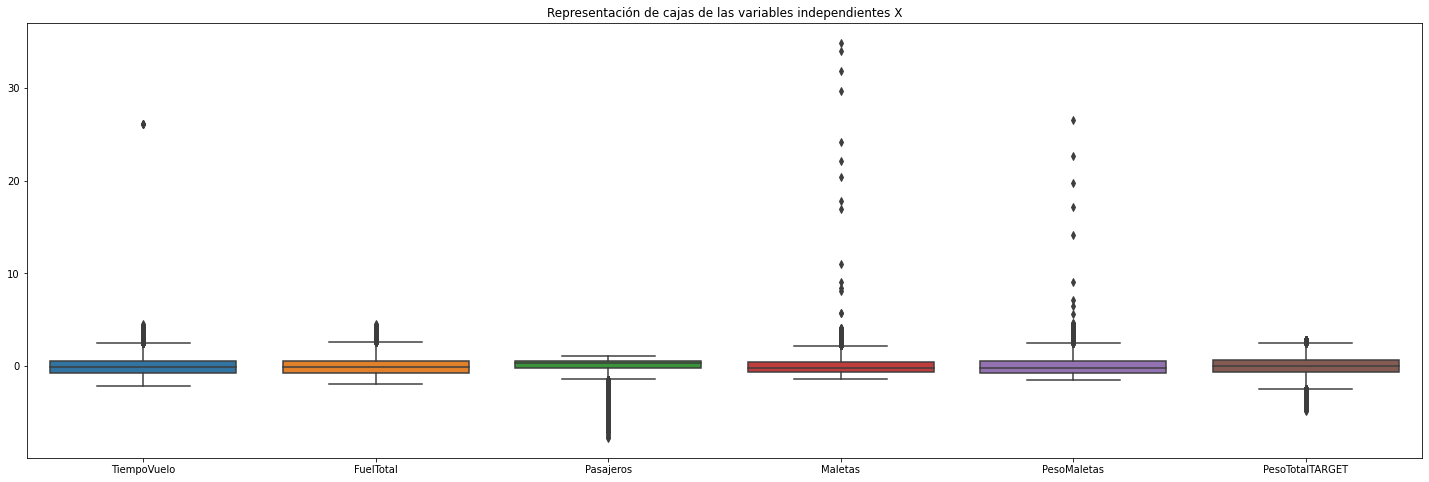

In [125]:
#Represento la dispersión de las variables predict continuas (normalizadas)


continuas=df_train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'DiaSalida', 'NumeroVuelo', 'Ruta'],axis=1) 

continuas_normalizado = (continuas-continuas.mean())/continuas.std()


plt.figure(figsize=(25,8))
sns.boxplot(data=continuas_normalizado)
plt.title(u'Representación de cajas de las variables independientes X')
_ = plt.xlabel('')

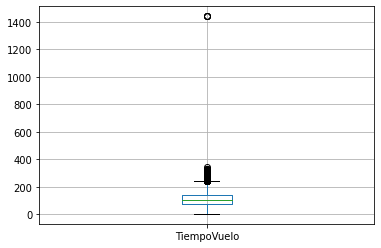

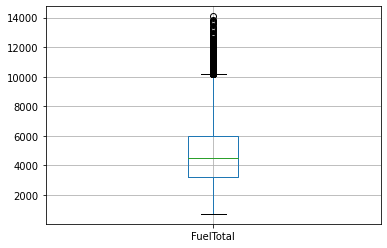

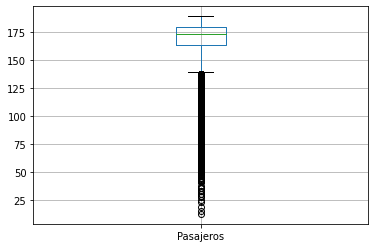

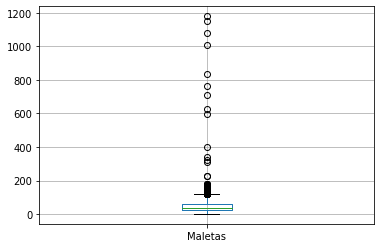

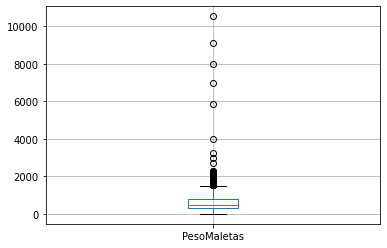

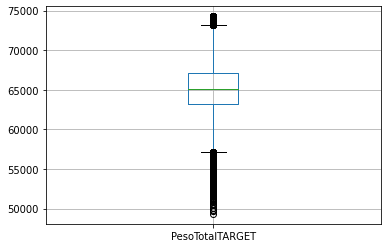

In [126]:
import matplotlib.pyplot as plt
for column in continuas:
  plt.figure()
  continuas.boxplot([column])


In [127]:
con_nulos=df_train.shape

In [128]:
#He decido eliminar algunos de los registros en los que sus valores para las variables 'TiempoVuelo', 'Maletas' y 'PesoMaletas' tenían el riesgo de ser atípicos

# Position de los Outliers que voy a eliminar:
print(np.where(df_train['TiempoVuelo']>800))
print(np.where(df_train['Maletas']>400))
print(np.where(df_train['PesoMaletas']>4000))

df_train = df_train.drop(df_train[df_train['TiempoVuelo']>800].index|df_train[df_train['Maletas']>400].index|df_train[df_train['PesoMaletas']>4000].index)


(array([15083, 17664, 24070, 25961]),)
(array([ 5369,  6647, 15130, 15139, 16263, 16870, 18416, 25455, 26004,
       26052]),)
(array([  149, 10519, 15868, 17083, 26004]),)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  


In [129]:

print('dimensión de train antes de eliminal los nulos: ',con_nulos)
print('dimension de train después de eliminal los nulos: ',df_train.shape)

dimensión de train antes de eliminal los nulos:  (26800, 11)
dimension de train después de eliminal los nulos:  (26782, 11)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

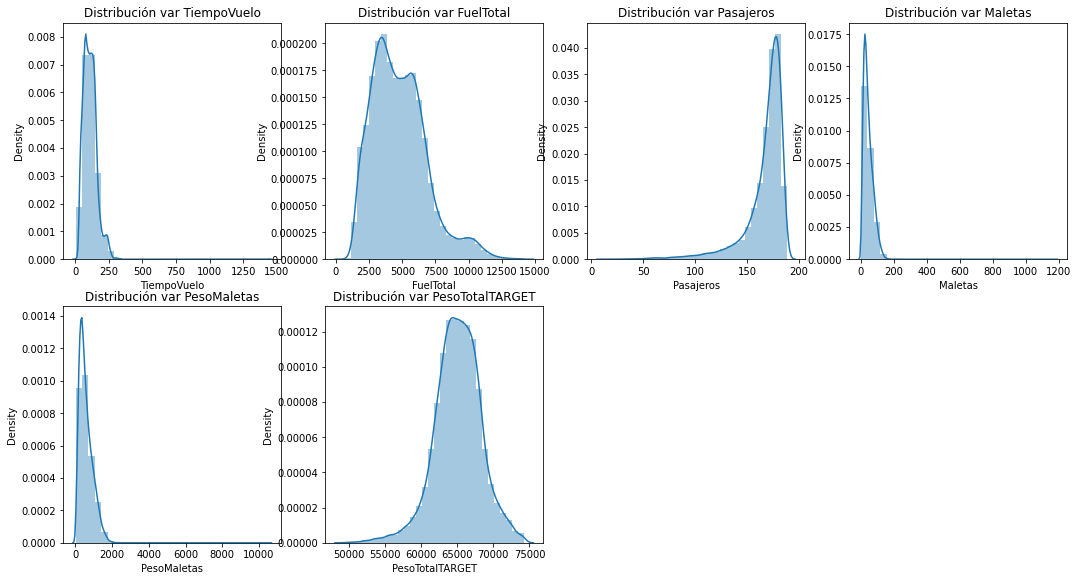

In [130]:
#Antes de eliminar los valores extremos
plt.figure(figsize=(18,20))
for i, column in enumerate(continuas.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(continuas[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

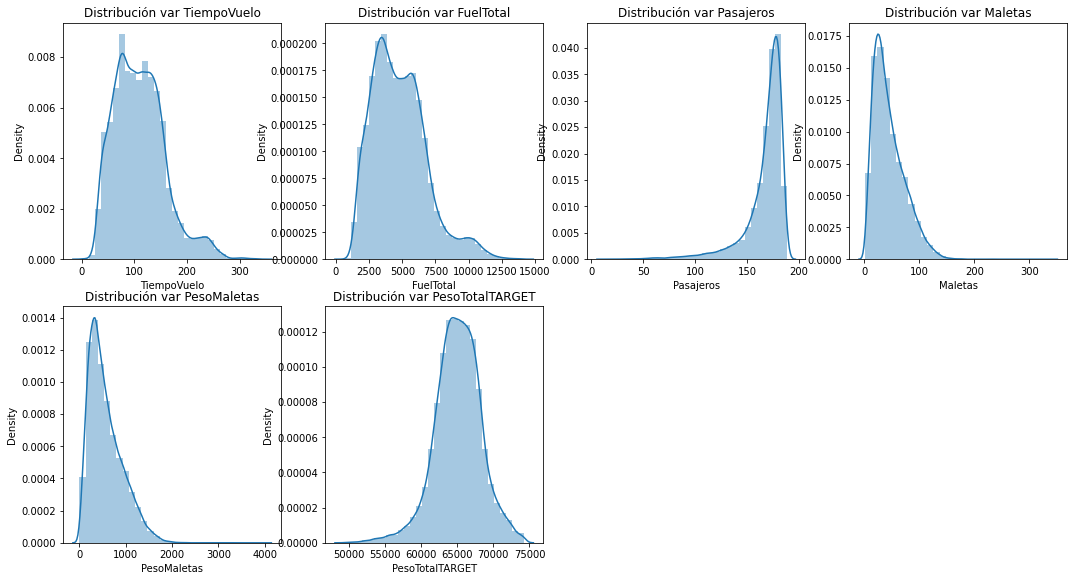

In [131]:
#Mejora después de eliminar valores extremos
continuas=df_train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'DiaSalida', 'NumeroVuelo', 'Ruta'],axis=1) 
plt.figure(figsize=(18,20))
for i, column in enumerate(continuas.columns):
    plt.subplot(4, 4, i+1)
    sns.distplot(continuas[column], bins=30)
    plt.title('Distribución var {}'.format(column))
plt.show()

**Correlaciones vs target:**

In [132]:
#Divido df_train entre las variables predictoras y la target

X_train = df_train.drop('PesoTotalTARGET', axis=1)
Y_train = df_train.loc[: , ["PesoTotalTARGET"]]


In [133]:
# Función que representa gráficos de dispersión de las variables en X en función a la variable Y

def relaciones_vs_target_reg(X, Y, return_type='axes'):
    fig_tot = (len(X.columns))
    fig_por_fila = 4.
    tamanio_fig = 5.
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+6, num_filas*tamanio_fig+6 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.regplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

In [134]:
corr_matrix = df_train.corr(method='pearson')


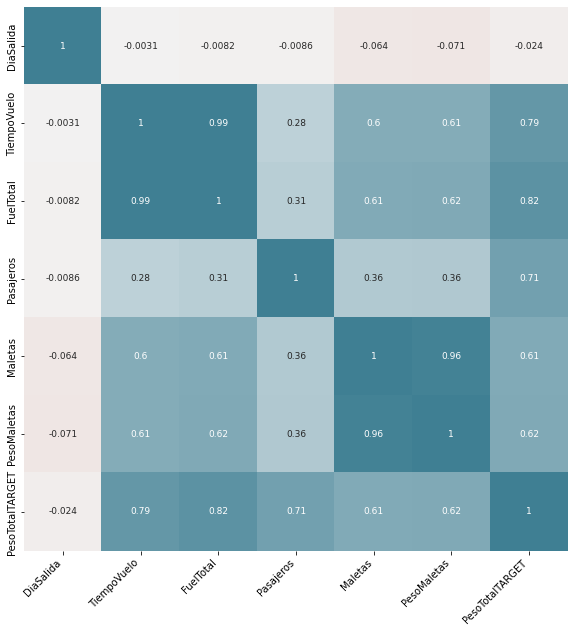

In [135]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 9},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 10)

In [136]:
correlaciones_target = corr_matrix.values[ -1, : -1]
indices_inversos =  abs(correlaciones_target[ : ]).argsort()[ : : -1]
diccionario = {}
for nombre, correlacion in zip( X_train.columns[indices_inversos], list(correlaciones_target[indices_inversos] ) ):
    diccionario[nombre] = correlacion
pd.DataFrame.from_dict(diccionario, orient='index', columns=['Correlación con la target'])

,Correlación con la target
AeropuertoSalida,0.822656
NumeroVuelo,0.786183
AeropuertoLlegada,0.706333
TiempoVuelo,0.620787
Ruta,0.614079
DiaSalida,-0.024022


**Estandarización de los datos:**

In [137]:
#importante estandarizar antes de realizar el one hot encoding 
obj_escalar = StandardScaler()
X_train[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']] = obj_escalar.fit_transform(X_train[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']])
#df_test[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']] = obj_escalar.fit_transform(df_test[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']])
df_test[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']] = obj_escalar.transform(df_test[['DiaSalida','TiempoVuelo','FuelTotal','Pasajeros','Maletas','PesoMaletas']])
'''
obj_escalar = StandardScaler()
X_train = obj_escalar.fit_transform(X_train)
df_test = obj_escalar.fit_transform(df_test)
'''

'\nobj_escalar = StandardScaler()\nX_train = obj_escalar.fit_transform(X_train)\ndf_test = obj_escalar.fit_transform(df_test)\n'

In [138]:
X_train.dtypes

DiaSalida            float64
NumeroVuelo           object
AeropuertoSalida      object
AeropuertoLlegada     object
Ruta                  object
TiempoVuelo          float64
FuelTotal            float64
Pasajeros            float64
Maletas              float64
PesoMaletas          float64
dtype: object

In [139]:
'''
Sospecho que las variables NumeroVuelo AeropuertoSalida AeropuertoLlegada y Ruta estan muy relacionadas entre si (Dependencia entre variables predictoras)


Me quedaré únicamente con la variable Ruta y la transformaré a valores numéricos con One-Hot-Encoding
'''
encoding_Ruta=pd.DataFrame(pd.get_dummies(X_train.Ruta, prefix='Ruta'))
#encoding_AeropuertoLlegada=pd.DataFrame(pd.get_dummies(df_train.AeropuertoLlegada, prefix='AeropuertoLlegada'))
#encoding_AeropuertoSalida=pd.DataFrame(pd.get_dummies(df_train.AeropuertoSalida, prefix='AeropuertoSalida'))
#encoding_NumeroVuelo=pd.DataFrame(pd.get_dummies(df_train.NumeroVuelo, prefix='NumeroVuelo'))


#df_train=df_train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'NumeroVuelo', 'Ruta'],axis=1) 

#df_train=pd.concat([df_train,encoding_Ruta,encoding_AeropuertoLlegada,encoding_AeropuertoSalida,encoding_NumeroVuelo],1)
X_train=pd.concat([X_train,encoding_Ruta],1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  app.launch_new_instance()


In [140]:
#Exactamente lo mismo para el conjunto test:

encoding_Ruta_t=pd.DataFrame(pd.get_dummies(df_test.Ruta, prefix='Ruta'))
#encoding_AeropuertoLlegada_t=pd.DataFrame(pd.get_dummies(df_test.AeropuertoLlegada, prefix='AeropuertoLlegada'))
#encoding_AeropuertoSalida_t=pd.DataFrame(pd.get_dummies(df_test.AeropuertoSalida, prefix='AeropuertoSalida'))
#encoding_NumeroVuelo_t=pd.DataFrame(pd.get_dummies(df_test.NumeroVuelo, prefix='NumeroVuelo'))


#df_test=df_test.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'NumeroVuelo', 'Ruta'],axis=1) 

#df_test=pd.concat([df_test,encoding_Ruta_t,encoding_AeropuertoLlegada_t,encoding_AeropuertoSalida_t,encoding_NumeroVuelo_t],1)
df_test=pd.concat([df_test,encoding_Ruta_t],1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  if sys.path[0] == '':


In [141]:
'''
Añado tanto para df_train como para df_test las columnas de 'Ruta' que les falta para que las variables de los dos dataframes sean las mismas.

Esto me permite aplicar el modelo de regresión sobre el conjunto de test

'''

#valores unicos columna ruta para train
a=np.asarray(df_test.columns)
b=np.asarray(X_train.columns)

c=np.append(a,a)

d=np.append(c,b)

#valores unicos columna ruta para test
e=np.asarray(df_test.columns)
f=np.asarray(X_train.columns)

g=np.append(f,f)
h=np.append(g,e)

from collections import Counter                                                                                                                                                                                                                                                   

ba = Counter(h) 
bb= Counter(d)   
unicos_train=[i for i,j in ba.items() if j==1] #Columnas que tiene df_test poro no df_train
unicos_test=[i for i,j in bb.items() if j==1]  #Columnas que tiene df_train poro no df_test

#Añado las columnas a cada dataframe:
df_test = df_test.reindex(columns = df_test.columns.tolist() + unicos_test)
X_train = X_train.reindex(columns = X_train.columns.tolist() + unicos_train)


In [142]:
X_train=X_train.convert_dtypes(convert_integer=True)
df_test=df_test.convert_dtypes(convert_integer=True)

In [143]:

a=np.asarray(X_train.columns)
n=0
for i in a:
  X_train[i] = pd.to_numeric(X_train[i], errors='coerce')
  n=n+1
  if n> len(a):
    break


In [144]:
print('Rutas añadidas al conjunto train: ',len(unicos_train))
print('Rutas añadidas al conjunto test: ',len(unicos_test))
print(X_train.shape)
print(df_test.shape)
#los dos dataframes se quedan con el mismo número y nombre de columnas

Rutas añadidas al conjunto train:  46
Rutas añadidas al conjunto test:  1084
(26782, 2588)
(1916, 2588)


In [145]:
#Elimino las variables object para quedarme con el resultado del one-hot-encoding de 'Ruta'
df_test=df_test.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'NumeroVuelo', 'Ruta'],axis=1) 
X_train=X_train.drop(['AeropuertoLlegada', 'AeropuertoSalida', 'NumeroVuelo', 'Ruta'],axis=1)

In [146]:

#Para evitar ---->   float() argument must be a string or a number, not 'NAType'

df_test=df_test.fillna(0)
X_train=X_train.fillna(0)
Y_train=Y_train.fillna(0)


In [147]:

X_train_cp=X_train.copy()
Y_train_cp=Y_train.copy()
df_test_cp=df_test.copy()

**Modelo de regresión con NN utilizando Tensorflow y Keras**

In [148]:
#Para seleccionar el modelo más apropiado dividiré el conjunto train para analizar los errores de predicción sobre este dataset.

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)


In [149]:
def constructor_modelo1():
    # Definición del modelo
    modelo = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[X_train2.shape[1]]),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)])
    
    # Definición del optimizador
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    # Compilación del modelo
    modelo.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return modelo

In [150]:
model = constructor_modelo1()

In [151]:

#ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type list)
X_train=np.asarray(X_train).astype(np.float32)
Y_train=np.asarray(Y_train).astype(np.float32)
df_test=np.asarray(df_test).astype(np.float32)


X_train2=np.asarray(X_train2).astype(np.float32)
Y_train2=np.asarray(Y_train2).astype(np.float32)
X_test2=np.asarray(X_test2).astype(np.float32)
Y_test2=np.asarray(Y_test2).astype(np.float32)


In [152]:
model.fit(X_train2, Y_train2)

670/670 [==============================] - 3s 3ms/step - loss: 4214510592.0000 - mae: 64838.2773 - mse: 4214510592.0000


In [153]:
X_train2.shape[1] #Número de variables input

2584

In [154]:

print(df_test.shape)

(1916, 2584)


In [155]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                165440    
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 167,553
Trainable params: 167,553
Non-trainable params: 0
_________________________________________________________________


In [156]:
# Muestro un punto por cada una de las épocas completadas
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 100
historico = model.fit(X_train2, Y_train2, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................

In [157]:
hist = pd.DataFrame(historico.history)
hist['epoch'] = historico.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
95,455145.34375,439.347168,455145.34375,614376.5625,512.747498,614376.5625,95
96,455448.59375,438.658630,455448.59375,612809.1250,508.676300,612809.1250,96
97,456270.34375,438.272217,456270.34375,609483.2500,514.196228,609483.2500,97
98,454022.87500,437.980713,454022.87500,620279.6250,512.028503,620279.6250,98
99,455523.37500,439.067383,455523.37500,617420.7500,519.770935,617420.7500,99


In [158]:
def represento_historico(historico):
    hist = pd.DataFrame(historico.history)
    hist['epoch'] = historico.epoch

    plt.figure(figsize=(20,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error absoluto medio [MAE]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Error de validación')
    plt.title('Error MAE en entrenamiento y en test')
    #plt.ylim([0,5])
    plt.legend()

    plt.figure(figsize=(20,7))
    plt.xlabel('Epoch')
    plt.ylabel('Error cuadrático medio [MSE]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Error de entrenamiento')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Error de validación')
    plt.title('Error MSE en entrenamiento y en test')
    #plt.ylim([0,20])
    plt.legend()
    plt.show()



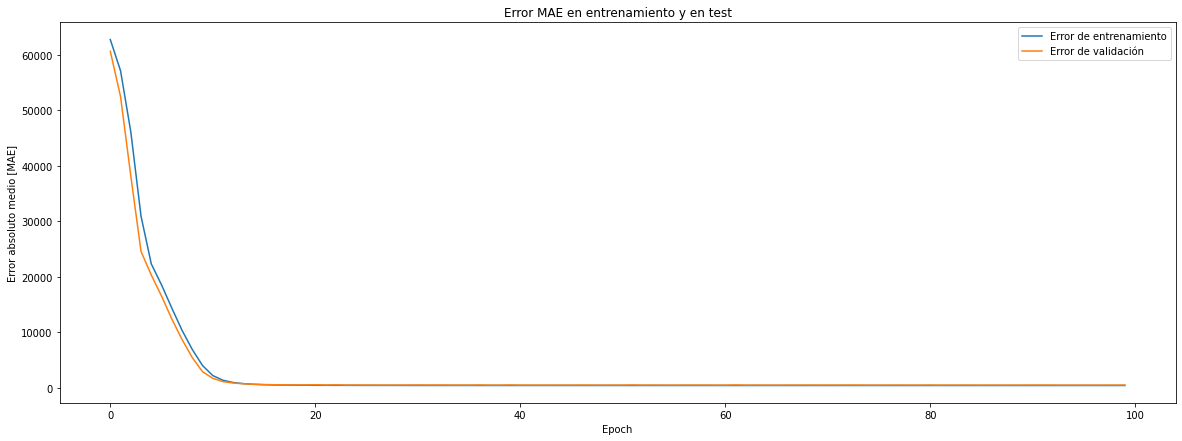

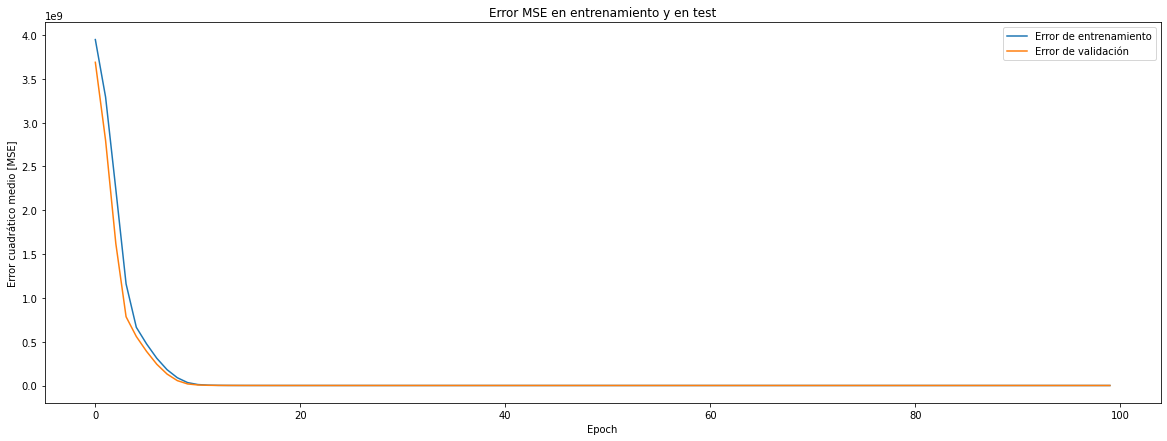

In [159]:
represento_historico(historico)

Para evitar el sobreajuste utilizo EarlyStoping.

El método de detención temprana tiene como objetivo resolver el problema de que el número de épocas debe establecerse manualmente. También puede considerarse como un método de regularización que puede evitar el sobreajuste de la red.



.............................................................

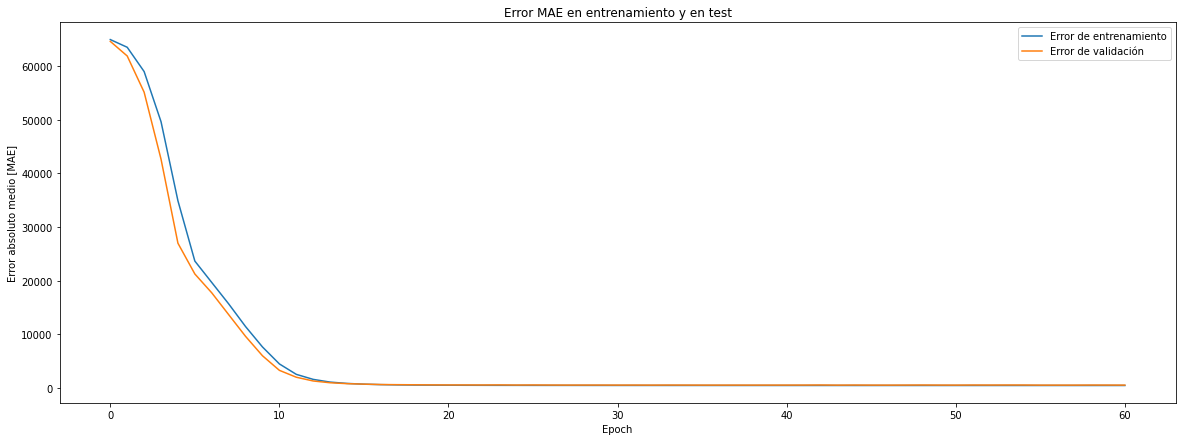

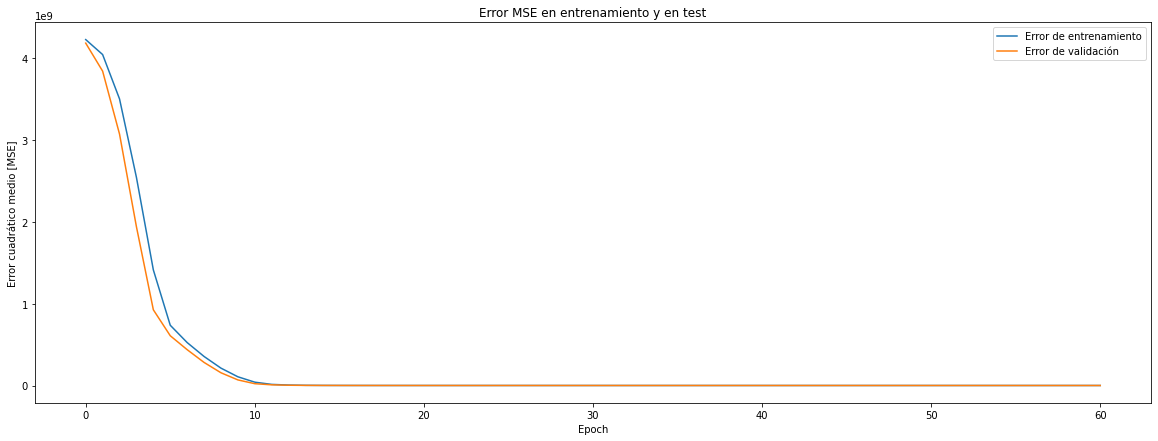

In [160]:
model2 = constructor_modelo1()

# En monitor es el valor a monitorizar, que en este caso puede ser uno de los siguientes:
# [loss, mae, mse, val_loss, val_mae, val_mse]
# Patience es el número de épocas sin mejora antes de parar el entrenamiento
early_stop = keras.callbacks.EarlyStopping(monitor='val_mse', patience=10)

history = model2.fit(X_train2, Y_train2, 
                    epochs=EPOCHS,
                    validation_split = 0.2, 
                    verbose=0, 
                    callbacks=[early_stop, PrintDot()])

represento_historico(history)

In [161]:
loss, mae, mse = model.evaluate(X_train2, Y_train2, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

670/670 - 1s - loss: 478746.4062 - mae: 450.1942 - mse: 478746.4062 - 1s/epoch - 2ms/step
Testing set Mean Abs Error: 450.19 MPG


In [162]:
hist2 = pd.DataFrame(history.history)
hist2.head(3)

,loss,mae,mse,val_loss,val_mae,val_mse
0,4.227657e+09,64939.820312,4.227657e+09,4.184316e+09,64604.324219,4.184316e+09
1,4.044696e+09,63504.078125,4.044696e+09,3.842002e+09,61879.390625,3.842002e+09
2,3.502523e+09,58978.542969,3.502523e+09,3.072947e+09,55134.433594,3.072947e+09


**Analizo errores**

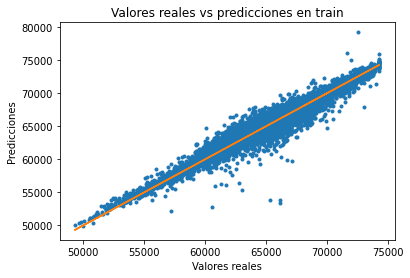

In [163]:
Y_train_pred = model.predict(X_train2)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_train2, Y_train_pred, '.', Y_train2, Y_train2, '-')

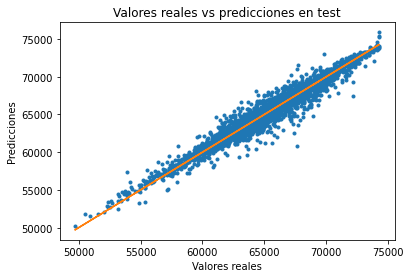

In [164]:
Y_test_pred = model.predict(X_test2)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_test2, Y_test_pred, '.', Y_test2, Y_test2, '-')

In [165]:
error_mse_train = round(mean_squared_error(Y_train2, Y_train_pred),2)
error_mse_test = round(mean_squared_error(Y_test2, Y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))
print('Raiz del error cuadrático medio (RECM): ',np.sqrt(error_mse_test))
RECM_modelo1=np.sqrt(error_mse_test)

El error cuadrático medio en train es: 478746.5625
El error cuadrático medio en test es: 541538.0
Raiz del error cuadrático medio (RECM):  735.89264


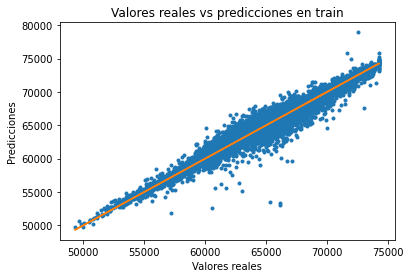

In [166]:
Y_train_pred = model2.predict(X_train2)
plt.title('Valores reales vs predicciones en train')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_train2, Y_train_pred, '.', Y_train2, Y_train2, '-')

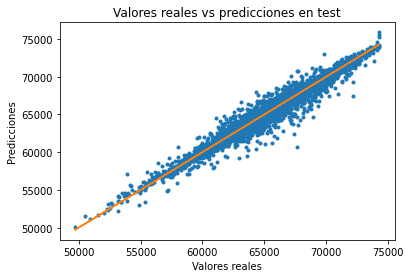

In [181]:
Y_test_pred = model2.predict(X_test2)
plt.title('Valores reales vs predicciones en test')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
_ = plt.plot(Y_test2, Y_test_pred, '.', Y_test2, Y_test2, '-')

In [182]:
error_mse_train = round(mean_squared_error(Y_train2, Y_train_pred),2)
error_mse_test = round(mean_squared_error(Y_test2, Y_test_pred),2)
print('El error cuadrático medio en train es: {}'.format(error_mse_train))
print('El error cuadrático medio en test es: {}'.format(error_mse_test))
print('Raiz del  error cuadrático medio (RECM): ',np.sqrt(error_mse_test))
RECM_modelo2=np.sqrt(error_mse_test)

El error cuadrático medio en train es: 477933.625
El error cuadrático medio en test es: 538910.125
Raiz del  error cuadrático medio (RECM):  734.105


**Predecir la target de test**

In [169]:
#Entreno otra vez las dos redes neuronales, esta vez con la totalidad de train
model.fit(X_train, Y_train)

model2.fit(X_train2, Y_train2, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

837/837 [==============================] - 3s 3ms/step - loss: 496613.6875 - mae: 464.2016 - mse: 496613.6875

.....................

In [170]:
#prediccion primeros 10 registros para test
pred_Sequential = pd.DataFrame(model.predict(df_test),columns=['pred_Sequential'])
pred_Sequential.head(10)

,pred_Sequential
0,68063.593750
1,64372.054688
2,63663.687500
3,67621.906250
4,67265.265625
5,67115.156250
6,63669.953125
7,63268.050781
8,68450.421875
9,64211.132812


In [171]:
#Error en pred_Sequencial:


In [172]:
#prediccion primeros 10 registros para test

pred_EarlyStopping = pd.DataFrame(model2.predict(df_test),columns=['pred_EarlyStopping'])
pred_EarlyStopping.head(10)

,pred_EarlyStopping
0,67939.273438
1,64248.593750
2,63511.921875
3,67552.453125
4,67068.859375
5,67065.867188
6,63160.585938
7,63036.074219
8,68588.695312
9,63912.218750


**Modelo de regresión no lineal. RandomForest**

In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_cp, Y_train_cp, test_size=0.2, random_state=0)

Optimizando max_depth y n_estimators con GridSearch

In [174]:
#modelo = RandomForestRegressor()
#parametros = {"n_estimators": [10,50], "max_depth":range(1,20)}

regressor=RandomForestRegressor(n_estimators = 100, random_state = 40)
regressor.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestRegressor(random_state=40)

In [175]:

Y_pred = regressor.predict(X_test)
print('Error absoluto medio en test:', metrics.mean_absolute_error(Y_test, Y_pred))
print('El error cuadrático medio (ECM) :', metrics.mean_squared_error(Y_test, Y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print('raíz del error cuadrático medio (RECM) modelo RandomForest :', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)),'\n\n')
RECM_randomforest=np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))
'''
Y_pred = regressor.predict(X_train)
print('Error absoluto medio en train:', metrics.mean_absolute_error(Y_train, Y_pred))
print('El error cuadrático medio (ECM) en train es:', metrics.mean_squared_error(Y_train, Y_pred))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
gg=print('raíz del error cuadrático medio (RECM) en train:', np.sqrt(metrics.mean_squared_error(Y_train, Y_pred)))
'''

Error absoluto medio en test: 628.4099309314915
El error cuadrático medio (ECM) : 745210.316463319
raíz del error cuadrático medio (RECM) modelo RandomForest : 863.2556495403427 




"\nY_pred = regressor.predict(X_train)\nprint('Error absoluto medio en train:', metrics.mean_absolute_error(Y_train, Y_pred))\nprint('El error cuadrático medio (ECM) en train es:', metrics.mean_squared_error(Y_train, Y_pred))\n#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))\ngg=print('raíz del error cuadrático medio (RECM) en train:', np.sqrt(metrics.mean_squared_error(Y_train, Y_pred)))\n"

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


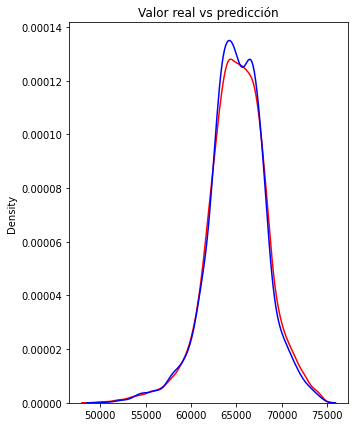

In [176]:
import seaborn as sns
plt.figure(figsize=(5, 7))


ax = sns.distplot(Y_train, hist=False, color="r", label="Actual Value")
sns.distplot(Y_pred, hist=False, color="b", label="Fitted Values" , ax=ax)


plt.title('Valor real vs predicción')


plt.show()
plt.close()

**Predecir sobre test con RandomForest**

In [177]:
Y_pred = regressor.predict(df_test)
pred_RandomForest=pd.DataFrame({'pred_RandomForest':Y_pred})
pred_RandomForest.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  "X does not have valid feature names, but"


,pred_RandomForest
0,66935.38
1,65340.90
2,63706.36
3,68030.17
4,67177.88
5,67628.97
6,63271.82
7,61462.21
8,68789.61
9,61802.84


Teniendo en cuenta que la media de pesos totales es 65000 las predicciones parecen ajustarse bien.

**Conclusiones**

In [178]:
predicciones=pd.concat([pred_Sequential,pred_EarlyStopping, pred_RandomForest], axis=1)
predicciones.describe()


,pred_Sequential,pred_EarlyStopping,pred_RandomForest
count,1916.000000,1916.000000,1916.000000
mean,65707.242188,65575.343750,65440.002954
std,3744.906738,3936.720703,2888.271387
min,54097.148438,53932.246094,53274.030000
25%,63764.041992,63439.066406,63446.392500
50%,65454.906250,65289.947266,65303.215000
75%,67394.703125,67383.513672,67274.610000
max,160416.265625,163398.296875,74236.900000


In [179]:
predicciones.head(10)#Las primeras 10 predicciones de la variable target de test son parecidas para los tres modelos

,pred_Sequential,pred_EarlyStopping,pred_RandomForest
0,68063.593750,67939.273438,66935.38
1,64372.054688,64248.593750,65340.90
2,63663.687500,63511.921875,63706.36
3,67621.906250,67552.453125,68030.17
4,67265.265625,67068.859375,67177.88
5,67115.156250,67065.867188,67628.97
6,63669.953125,63160.585938,63271.82
7,63268.050781,63036.074219,61462.21
8,68450.421875,68588.695312,68789.61
9,64211.132812,63912.218750,61802.84


In [183]:
#RMSE_forest=metrics.mean_squared_error(Y_test, Y_pred)

print('Raiz error cuadrático medio en el modelo secuencial: ',RECM_modelo1)
print('Raiz error cuadrático medio en el modelo EarlyStopping: ',RECM_modelo2)
print('Raiz error cuadrático medio en el modelo RandomForest: ',RECM_randomforest)

Raiz error cuadrático medio en el modelo secuencial:  735.89264
Raiz error cuadrático medio en el modelo EarlyStopping:  734.105
Raiz error cuadrático medio en el modelo RandomForest:  863.2556495403427


El mejor modelo sería la red neuronal EarlyStoping

In [184]:
#La predicción de los pesos totales utilizando el modelo seleccionado serían las siguientes:

pred_EarlyStopping

,pred_EarlyStopping
0,67939.273438
1,64248.593750
2,63511.921875
3,67552.453125
4,67068.859375
...,...
1911,66194.539062
1912,68688.007812
1913,66703.468750
1914,67094.007812
